In [1]:
import os

os.chdir('..')

In [3]:
os.getcwd()

'/home/wedl/work/conv-recognition'

In [4]:
import sys
import os

if '.' not in sys.path:
    sys.path.append('.')

%load_ext autoreload
%autoreload 2

# Import Data

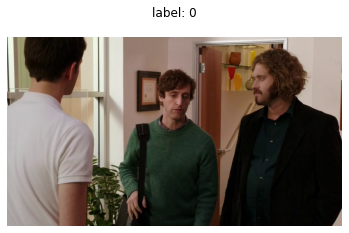

In [18]:
from conv_recognition.dataset import UcoDataset
import matplotlib.pyplot as plt

data = UcoDataset('data/ucolaeodb', 'sv01')
img, label = data[0]

plt.imshow(img.permute(1,2,0))
plt.title(f'label: {label}')
plt.axis('off')
plt.show()

# Face Detection

In [19]:
from face_detection import RetinaFace
detector = RetinaFace(0)

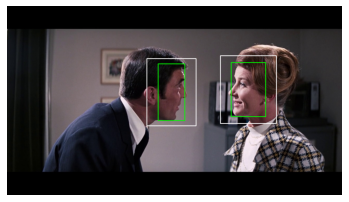

0 found


In [26]:
import cv2 
from copy import copy

frame = cv2.imread('data/datasets/scene2/00290.jpg')
img_numpy = frame # copy(img.permute(1,2,0).cpu().numpy())
faces = detector(img_numpy)

face_tensors = []
for box, landmarks, score in faces:
    if score < 0.9:
        continue
    x_min = int(box[0])
    y_min = int(box[1])
    x_max = int(box[2])
    y_max = int(box[3])

    bbox_width = abs(x_max - x_min)
    bbox_height = abs(y_max - y_min)

    x_min2 = max(0, x_min-int(0.2*bbox_height))
    y_min2 = max(0, y_min-int(0.2*bbox_width))
    x_max2 = x_max+int(0.2*bbox_height)
    y_max2 = y_max+int(0.2*bbox_width)

    # face_tensors.append(img[:, y_min:y_max, x_min:x_max])

    cv2.rectangle(img_numpy, (x_min, y_min), (x_max, y_max), (0,255,0), 2)
    cv2.rectangle(img_numpy, (x_min2, y_min2), (x_max2, y_max2), (255,255,255), 2)

plt.imshow(img_numpy[:,:,[2,1,0]])
plt.axis('off')
plt.show()
print(f'{len(face_tensors)} found')
Image.fromarray(img_numpy[:,:,[2,1,0]]).save('data/samples/face_sample.png')

In [27]:
plt.imshow(face_tensors[1].permute(1,2,0))
plt.axis('off')
plt.show()

IndexError: list index out of range

# Detect Head Pose

In [29]:
# if f'../extern/6DRepNet' not in sys.path:
#     sys.path.append(f'../extern/6DRepNet')

from conv_recognition.model import SixDRepNet
from torchvision import transforms
import torch
import os

gpu_id = 0

In [30]:
snapshot_path = 'data/models/6DRepNet_300W_LP_AFLW2000.pth'
transformations = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
model = SixDRepNet(backbone_name='RepVGG-B1g2',
                   backbone_file='',
                   deploy=True,
                   pretrained=False)
detector = RetinaFace(gpu_id=gpu_id)

saved_state_dict = torch.load(snapshot_path, map_location='cpu')
if 'model_state_dict' in saved_state_dict:
    model.load_state_dict(saved_state_dict['model_state_dict'])
else:
    model.load_state_dict(saved_state_dict)

model.cuda(gpu_id)
model.eval()

print('successfully loaded models')

successfully loaded models


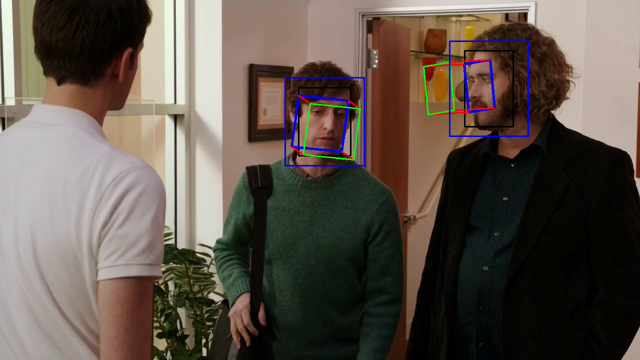

In [11]:
from PIL import Image
import conv_recognition.utils as utils
import numpy as np

def get_poses(frame):
    faces = detector(frame)
    for box, landmarks, score in faces:
        if score < 0.95:
            continue
        x_min = int(box[0])
        y_min = int(box[1])
        x_max = int(box[2])
        y_max = int(box[3])
        bbox_width = abs(x_max - x_min)
        bbox_height = abs(y_max - y_min)

        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0,0,0), 2)
        x_min = max(0, x_min-int(0.2*bbox_height))
        y_min = max(0, y_min-int(0.2*bbox_width))
        x_max = x_max+int(0.2*bbox_height)
        y_max = y_max+int(0.2*bbox_width)

        img = frame[y_min:y_max, x_min:x_max]
        img = Image.fromarray(img)
        img = img.convert('RGB')
        img = transformations(img)

        img = torch.Tensor(img[None, :]).cuda(gpu_id)

        pred = model(img)
        euler = utils.compute_euler_angles_from_rotation_matrices(pred)*180/np.pi

        p_pred_deg = euler[:, 0].cpu().item()
        y_pred_deg = euler[:, 1].cpu().item()
        r_pred_deg = euler[:, 2].cpu().item()
        
        # tdx, tdy, yaw, pitch, roll, size
        center_x = x_min + int(.5*(x_max-x_min))
        center_y = y_min + int(.5*(y_max-y_min))
        utils.plot_pose_cube(frame,  
            center_x, center_y, 
            y_pred_deg, p_pred_deg, r_pred_deg,
            size=bbox_width)
        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0,0,255), 2)
    return frame

frame = cv2.imread('data/datasets/scene2/00290.jpg')
with torch.no_grad():
    frame = get_poses(copy(img.permute(1,2,0).cpu().numpy()))
Image.fromarray(frame).resize((640, 360))

# PoseEstimator

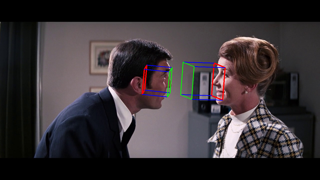

In [11]:
from PIL import Image
from conv_recognition.pose_estimator import PoseEstimator
import cv2

frame = cv2.imread('data/datasets/scene2/00290.jpg')
estimator = PoseEstimator()

head_poses = estimator.get_poses(frame)
result = estimator.draw_head_poses(frame, head_poses)
# frame = estimator.draw_viewing_direction(frame, head_poses)
img = Image.fromarray(result[:,:,[2,1,0]])
img.save('data/samples/head_pose.jpg')

img.resize((320, 180))

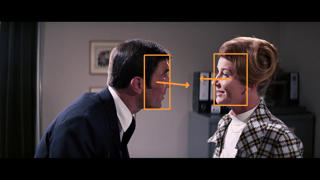

In [48]:
from conv_recognition.laeo import get_colors

frame = cv2.imread('data/datasets/scene2/00290.jpg')

head_poses = estimator.get_poses(frame)
colors = get_colors(head_poses)
result=estimator.draw_bbox(frame, head_poses, inplace=False, colors=colors)
estimator.draw_viewing_direction(result, head_poses, inplace=True, colors=colors)

img = Image.fromarray(result[:,:,[2,1,0]])
img.save('data/samples/laeo.jpg')
Image.fromarray(result[:,:,[2,1,0]]).resize((320, 180))

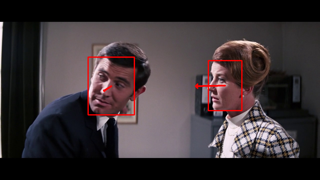

In [47]:
frame = cv2.imread('data/datasets/scene2/00205.jpg')

head_poses = estimator.get_poses(frame)
colors = get_colors(head_poses)
result=estimator.draw_bbox(frame, head_poses, inplace=False, colors=colors)
estimator.draw_viewing_direction(result, head_poses, inplace=True, colors=colors)

img = Image.fromarray(result[:,:,[2,1,0]])
img.save('data/samples/not-laeo.jpg')
Image.fromarray(result[:,:,[2,1,0]]).resize((320, 180))

-inf inf
-466.7533268912624 -183.49859330627052
-inf inf
547.650302734747 362.59951550930737
1 intersects 0
[(1, 0)]
[(0, 0, 255), (0, 0, 255)]


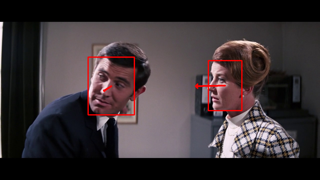

In [36]:
from math import cos, sin
from numpy.linalg import norm
from typing import List, Tuple
from conv_recognition.pose_estimator import HeadPose

def intersect(x_min, x_max, y_min, y_max, origin_x, origin_y, ray_x, ray_y):
    tmin, tmax = -np.infty, np.infty

    if ray_x != 0.0:
        tx1 = (x_min-origin_x)/ray_x
        tx2 = (x_max-origin_x)/ray_x

        tmin = max(tmin, min(tx1, tx2))
        tmax = min(tmax, max(tx1, tx2))

    if ray_y != 0.0:
        ty1 = (y_min-origin_y)/ray_y
        ty2 = (y_max-origin_y)/ray_y

        tmin = max(tmin, min(ty1, ty2))
        tmax = min(tmax, max(ty1, ty2))
    return tmax >= tmin and tmax > 0.0

def find_intersections(head_poses: HeadPose):
    intersections = []
    for i, hp in enumerate(head_poses):
        p = hp.pitch * np.pi / 180
        y = -(hp.yaw * np.pi / 180)
        ray_dir = np.array([sin(y), (-cos(y) * sin(p))])
        ray_dir /= norm(ray_dir)

        for j, hp2 in enumerate(head_poses):
            if i==j:
                continue
            x_min = hp2.center_x-hp2.bbox_width/2
            x_max = hp2.center_x+hp2.bbox_width/2
            y_min = hp2.center_y-hp2.bbox_height/2
            y_max = hp2.center_y+hp2.bbox_height/2
            if intersect(x_min, x_max, y_min, y_max, hp.center_x, hp.center_y, ray_dir[0], ray_dir[1]):
                intersections.append((i, j))
    return intersections

def find_laeo(intersections: List[Tuple[int, int]]):
    intersections_reversed = [tuple(reversed(i)) for i in intersections]
    intersections.sort()
    intersections_reversed.sort()
    laeo = []
    for i1, i2 in zip(intersections, intersections_reversed):
        if i1==i2 and tuple(reversed(i1)) not in laeo:
            laeo.append(i1)
    return laeo

def assign_colors(head_poses, laeo):
    laeo_colors = [
        (51, 153, 255),
        (51, 255, 255),
        (51, 51, 255),
        (153, 51, 255),
        (255, 51, 255),
        (255, 51, 153),
    ]
    colors = [(0, 0, 255) for _ in head_poses]
    counter = 0
    for i1, i2 in laeo:
        colors[i1] = laeo_colors[counter]
        colors[i2] = laeo_colors[counter]
        counter += 1
    return colors

head_poses = estimator.get_poses(frame)
intersections = find_intersections(head_poses)
laeo = find_laeo(intersections)
colors = assign_colors(head_poses, laeo)

result = estimator.draw_bbox(frame, head_poses, colors=colors)
estimator.draw_viewing_direction(result, head_poses, inplace=True, colors=colors)

Image.fromarray(result[:,:,[2,1,0]]).resize((320, 180))

In [40]:
file_names = os.listdir('data/images/scene2')
file_names.sort()
file_names

['0.jpg',
 '1.jpg',
 '10.jpg',
 '100.jpg',
 '101.jpg',
 '102.jpg',
 '103.jpg',
 '104.jpg',
 '105.jpg',
 '106.jpg',
 '107.jpg',
 '108.jpg',
 '109.jpg',
 '11.jpg',
 '110.jpg',
 '111.jpg',
 '112.jpg',
 '113.jpg',
 '114.jpg',
 '115.jpg',
 '116.jpg',
 '117.jpg',
 '118.jpg',
 '119.jpg',
 '12.jpg',
 '120.jpg',
 '121.jpg',
 '122.jpg',
 '123.jpg',
 '124.jpg',
 '125.jpg',
 '126.jpg',
 '127.jpg',
 '128.jpg',
 '129.jpg',
 '13.jpg',
 '130.jpg',
 '131.jpg',
 '132.jpg',
 '133.jpg',
 '134.jpg',
 '135.jpg',
 '136.jpg',
 '137.jpg',
 '138.jpg',
 '139.jpg',
 '14.jpg',
 '140.jpg',
 '141.jpg',
 '142.jpg',
 '143.jpg',
 '144.jpg',
 '145.jpg',
 '146.jpg',
 '147.jpg',
 '148.jpg',
 '149.jpg',
 '15.jpg',
 '150.jpg',
 '151.jpg',
 '152.jpg',
 '153.jpg',
 '154.jpg',
 '155.jpg',
 '156.jpg',
 '157.jpg',
 '158.jpg',
 '159.jpg',
 '16.jpg',
 '160.jpg',
 '161.jpg',
 '162.jpg',
 '163.jpg',
 '164.jpg',
 '165.jpg',
 '166.jpg',
 '167.jpg',
 '168.jpg',
 '169.jpg',
 '17.jpg',
 '170.jpg',
 '171.jpg',
 '172.jpg',
 '173.jpg',
 '17

In [ ]:
import cv2

cap = cv2.VideoCapture('')

# Validation

In [2]:
import os
os.chdir('..')

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

def calc_metrics(prediction_path, label_path):

    results = []

    scenes = os.listdir(prediction_path)
    scenes.sort()

    for scene in scenes:    

        pred_exist = False
        with open(f'{prediction_path}/{scene}', 'r') as f:
            predictions = f.readlines()
            predictions = np.array([int(p.split(' ')[1]) for p in predictions])
            pred_exist = True
        if not pred_exist:
            continue

        with open(f'{label_path}/{scene}', 'r') as f:
            labels = f.readlines()
            labels = np.array([int(l.split(' ')[1]) for l in labels])

        predictions = np.concatenate([predictions, np.zeros(len(labels)-len(predictions))])

        scene_name = scene[:-4]
        accuracy = accuracy_score(labels, predictions)
        precision = precision_score(labels, predictions)
        recall = recall_score(labels, predictions)
        results.append([scene_name, accuracy, precision, recall])
    return pd.DataFrame(results, columns=['scene', 'accuracy', 'precision', 'recall'])

prediction_path = 'data/laeonet_pred'
label_path = 'data/labels'
laeo_net_df = calc_metrics(prediction_path, label_path)
laeo_net_df['type'] = 'sota'
prediction_path = 'data/predictions'
pred_df = calc_metrics(prediction_path, label_path)
pred_df['type'] = 'own'

df = pd.concat([pred_df, laeo_net_df])
df

,scene,accuracy,precision,recall,type
0,scene1,0.928030,0.982968,0.821138,own
1,scene2,0.747788,0.963964,0.668750,own
2,scene4,0.907133,1.000000,0.425000,own
3,scene7,0.859606,0.935252,0.817610,own
0,scene1,0.807576,0.671965,0.945122,sota
1,scene2,0.846608,0.844322,0.960417,sota
2,scene4,0.888291,0.592965,0.983333,sota


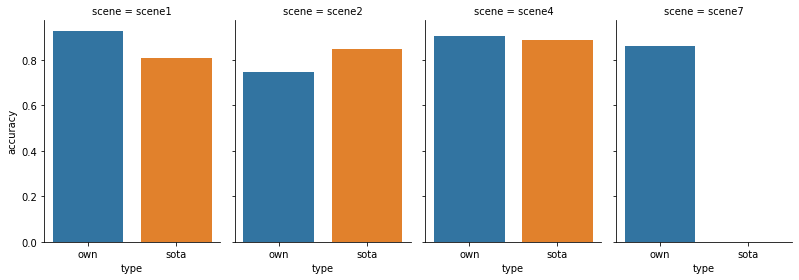

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = sns.catplot(data=df, x='type', y='accuracy', col='scene', kind='bar', height=4, aspect=.7)
plt.show()
fig.savefig('data/plots/accuracy.pdf')

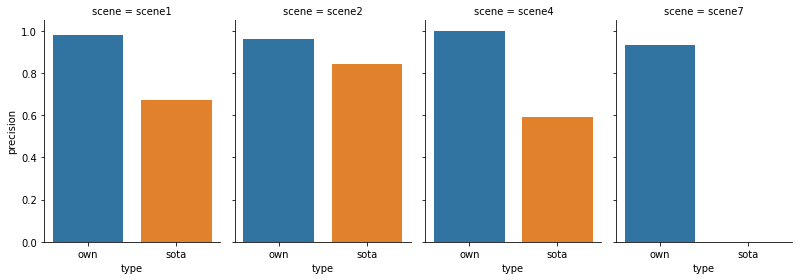

In [6]:
fig = sns.catplot(data=df, x='type', y='precision', col='scene', kind='bar', height=4, aspect=.7)
plt.show()
fig.savefig('data/plots/precision.pdf')

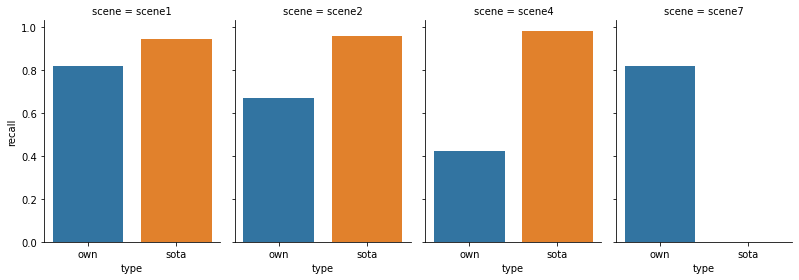

In [7]:
fig = sns.catplot(data=df, x='type', y='recall', col='scene', kind='bar', height=4, aspect=.7)
plt.show()
fig.savefig('data/plots/recall.pdf')